# Project 3 Code
- 09.19.2023
- Data Enrichment

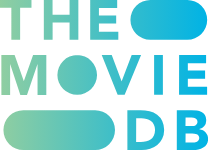

Data Source: https://datasets.imdbws.com

## Data Dictionary

**title.akas.tsv.gz**
- titleId (string) - a tconst, an alphanumeric unique identifier of the title
- ordering (integer) – a number to uniquely identify rows for a given titleId
- title (string) – the localized title
- region (string) - the region for this version of the title
- language (string) - the language of the title
- types (array) - Enumerated set of attributes for this alternative title. One or more of the following: "alternative", "dvd", "festival", "tv", "video", "working", "original", "imdbDisplay". New values may be added in the future without warning
- attributes (array) - Additional terms to describe this alternative title, not enumerated
- isOriginalTitle (boolean) – 0: not original title; 1: original title

**title.basics.tsv.gz**
- tconst (string) - alphanumeric unique identifier of the title
- titleType (string) – the type/format of the title (e.g. movie, short, tvseries, tvepisode, video, etc)
- primaryTitle (string) – the more popular title / the title used by the filmmakers on promotional materials at the point of release
- originalTitle (string) - original title, in the original language
- isAdult (boolean) - 0: non-adult title; 1: adult title
- startYear (YYYY) – represents the release year of a title. In the case of TV Series, it is the series start year
- endYear (YYYY) – TV Series end year. ‘\N’ for all other title types
- runtimeMinutes – primary runtime of the title, in minutes
- genres (string array) – includes up to three genres associated with the title

**title.ratings.tsv.gz**
- tconst (string) - alphanumeric unique identifier of the title
- averageRating – weighted average of all the individual user ratings
- numVotes - number of votes the title has received

In [1]:
# Install tmdbsimple (only need to run once)
!pip install tmdbsimple

In [2]:
# Standard Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymysql
pymysql.install_as_MySQLdb()
from urllib.parse import quote_plus as urlquote

# Additional Imports
import os, json, math, time, gzip
from yelpapi import YelpAPI
from tqdm.notebook import tqdm_notebook
import tmdbsimple as tmdb

In [3]:
# Load dataset URLs
# basics_url = "https://datasets.imdbws.com/title.basics.tsv.gz"
# ratings_url = "https://datasets.imdbws.com/title.ratings.tsv.gz"

In [4]:
# Read in the datasets    
# basics = pd.read_csv(basics_url, sep='\t', low_memory=False)
# ratings = pd.read_csv(ratings_url, sep='\t', low_memory=False)

In [5]:
# Read in the akas dataset
with gzip.open('Data/title-akas-us-only.csv', 'rb') as f:
    akas = pd.read_csv(f, encoding='utf-8', low_memory=False)

akas.head()

,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
0,tt0000001,6,Carmencita,US,NaN,imdbDisplay,NaN,0.0
1,tt0000002,7,The Clown and His Dogs,US,NaN,NaN,literal English title,0.0
2,tt0000005,10,Blacksmith Scene,US,NaN,imdbDisplay,NaN,0.0
3,tt0000005,1,Blacksmithing Scene,US,NaN,alternative,NaN,0.0
4,tt0000005,6,Blacksmith Scene #1,US,NaN,alternative,NaN,0.0


In [6]:
# Open saved basics file and preview again
basics = pd.read_csv("Data/title_basics.csv.gz", low_memory = False)
basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001.0,NaN,118,"Comedy,Fantasy,Romance"
1,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El tango del viudo y su espejo deformante,0,2020.0,NaN,70,Drama
2,tt0068865,movie,Lives of Performers,Lives of Performers,0,2016.0,NaN,90,Drama
3,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018.0,NaN,122,Drama
4,tt0088751,movie,The Naked Monster,The Naked Monster,0,2005.0,NaN,100,"Comedy,Horror,Sci-Fi"


In [7]:
# Open saved ratings file and preview again
ratings = pd.read_csv("Data/title_ratings.csv.gz", low_memory = False)
ratings.head()

,tconst,averageRating,numVotes
0,tt0035423,6.4,87572
1,tt0062336,6.4,180
2,tt0068865,5.4,74
3,tt0069049,6.7,7831
4,tt0088751,5.2,340


In [8]:
# Preview first 5 rows of akas dataset
akas.head()

,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
0,tt0000001,6,Carmencita,US,NaN,imdbDisplay,NaN,0.0
1,tt0000002,7,The Clown and His Dogs,US,NaN,NaN,literal English title,0.0
2,tt0000005,10,Blacksmith Scene,US,NaN,imdbDisplay,NaN,0.0
3,tt0000005,1,Blacksmithing Scene,US,NaN,alternative,NaN,0.0
4,tt0000005,6,Blacksmith Scene #1,US,NaN,alternative,NaN,0.0


In [9]:
# Preview first 5 rows of basics dataset
basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001.0,NaN,118,"Comedy,Fantasy,Romance"
1,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El tango del viudo y su espejo deformante,0,2020.0,NaN,70,Drama
2,tt0068865,movie,Lives of Performers,Lives of Performers,0,2016.0,NaN,90,Drama
3,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018.0,NaN,122,Drama
4,tt0088751,movie,The Naked Monster,The Naked Monster,0,2005.0,NaN,100,"Comedy,Horror,Sci-Fi"


In [10]:
# Preview first 5 rows of ratings dataset
ratings.head()

,tconst,averageRating,numVotes
0,tt0035423,6.4,87572
1,tt0062336,6.4,180
2,tt0068865,5.4,74
3,tt0069049,6.7,7831
4,tt0088751,5.2,340


In [11]:
# Make a copy of akas_us
akas_copy = akas.copy()

In [12]:
# Replace "\N" with np.nan and verify that it stuck
akas_copy.replace({'\\N':np.nan}, inplace=True)
akas_copy.head()

,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
0,tt0000001,6,Carmencita,US,NaN,imdbDisplay,NaN,0.0
1,tt0000002,7,The Clown and His Dogs,US,NaN,NaN,literal English title,0.0
2,tt0000005,10,Blacksmith Scene,US,NaN,imdbDisplay,NaN,0.0
3,tt0000005,1,Blacksmithing Scene,US,NaN,alternative,NaN,0.0
4,tt0000005,6,Blacksmith Scene #1,US,NaN,alternative,NaN,0.0


In [13]:
# Keep only US movies in the basics dataframe
basics_keepers = basics['tconst'].isin(akas_copy['titleId'])
basics_filtered = basics[basics_keepers]
basics_filtered

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001.0,NaN,118,"Comedy,Fantasy,Romance"
1,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El tango del viudo y su espejo deformante,0,2020.0,NaN,70,Drama
2,tt0068865,movie,Lives of Performers,Lives of Performers,0,2016.0,NaN,90,Drama
3,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018.0,NaN,122,Drama
4,tt0088751,movie,The Naked Monster,The Naked Monster,0,2005.0,NaN,100,"Comedy,Horror,Sci-Fi"
...,...,...,...,...,...,...,...,...,...
114437,tt9915436,movie,Vida em Movimento,Vida em Movimento,0,2019.0,NaN,70,Documentary
114438,tt9915872,movie,The Last White Witch,Boku no kanojo wa mahoutsukai,0,2019.0,NaN,97,"Comedy,Drama,Fantasy"
114439,tt9916170,movie,The Rehearsal,O Ensaio,0,2019.0,NaN,51,Drama
114440,tt9916190,movie,Safeguard,Safeguard,0,2020.0,NaN,95,"Action,Adventure,Thriller"


In [14]:
# Make a copy of basics_filtered
basics_filtered_copy = basics_filtered.copy()

In [15]:
# Replace "\N" with np.nan and verify that it stuck
basics_filtered_copy.replace({'\\N':np.nan}, inplace=True)
basics_filtered_copy.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001.0,NaN,118,"Comedy,Fantasy,Romance"
1,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El tango del viudo y su espejo deformante,0,2020.0,NaN,70,Drama
2,tt0068865,movie,Lives of Performers,Lives of Performers,0,2016.0,NaN,90,Drama
3,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018.0,NaN,122,Drama
4,tt0088751,movie,The Naked Monster,The Naked Monster,0,2005.0,NaN,100,"Comedy,Horror,Sci-Fi"


In [16]:
# Eliminate movies that are null for runtimeMinutes
# Eliminate movies that are null for genre
basics_filtered_copy = basics_filtered_copy.dropna(subset=['runtimeMinutes', 'genres'])

In [17]:
# Keep only titleType==Movie
basics_filtered_copy = basics_filtered_copy[basics_filtered_copy['titleType'] == 'movie']

In [18]:
# Convert the startYear column to float data type.
basics_filtered_copy['startYear'] = basics_filtered_copy['startYear'].astype(float)

In [19]:
# Filter the dataframe using startYear. Keep years between 2000-2021 (Including 2000 and 2021)
basics_filtered_copy = basics_filtered_copy[(basics_filtered_copy['startYear'] 
                                             >= 2000) & (basics_filtered_copy
                                                         ['startYear'] <= 2021)]

In [20]:
# Filter the ratings DataFrame based on tconst from basics_filtered_copy
ratings_filtered = ratings[ratings['tconst'].isin(basics_filtered_copy['tconst'])]

In [21]:
# Make a copy of ratings_filtered
ratings_filtered_copy = ratings_filtered.copy()

In [22]:
# Replace "\N" with np.nan in the ratings DataFrame
ratings_filtered_copy.replace({'\\N':np.nan}, inplace=True)
ratings_filtered_copy.head()

,tconst,averageRating,numVotes
0,tt0035423,6.4,87572
1,tt0062336,6.4,180
2,tt0068865,5.4,74
3,tt0069049,6.7,7831
4,tt0088751,5.2,340


In [23]:
# Run a final .info() on akas_us_copy dataframe
akas_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1452564 entries, 0 to 1452563
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   titleId          1452564 non-null  object 
 1   ordering         1452564 non-null  int64  
 2   title            1452564 non-null  object 
 3   region           1452564 non-null  object 
 4   language         4018 non-null     object 
 5   types            981678 non-null   object 
 6   attributes       47016 non-null    object 
 7   isOriginalTitle  1451222 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 88.7+ MB


In [24]:
# Run a final .info() on basics_filtered_copy dataframe
basics_filtered_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114442 entries, 0 to 114441
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tconst          114442 non-null  object 
 1   titleType       114442 non-null  object 
 2   primaryTitle    114442 non-null  object 
 3   originalTitle   114442 non-null  object 
 4   isAdult         114442 non-null  int64  
 5   startYear       114442 non-null  float64
 6   endYear         0 non-null       float64
 7   runtimeMinutes  114442 non-null  int64  
 8   genres          114442 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 8.7+ MB


In [25]:
# Run a final .info() on ratings_filtered_copy dataframe
ratings_filtered_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87547 entries, 0 to 87546
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tconst         87547 non-null  object 
 1   averageRating  87547 non-null  float64
 2   numVotes       87547 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 2.7+ MB


In [26]:
# Save akas_us_copy dataframe to csv file
akas_copy.to_csv("Data/title-akas-us-only.csv", compression='gzip', index=False)

In [27]:
# Save basics_filtered_copy dataframe to csv file
basics_filtered_copy.to_csv("Data/title_basics.csv.gz", compression='gzip', index=False)

In [28]:
# Save ratings_us_copy dataframe to csv file
ratings_filtered_copy.to_csv("Data/title_ratings.csv.gz", compression='gzip', index=False)

In [29]:
FOLDER = "Data/"
os.makedirs(FOLDER, exist_ok=True)
os.listdir(FOLDER)

['.ipynb_checkpoints',
 'final_tmdb_data_2000.csv.gz',
 'final_tmdb_data_2001.csv.gz',
 'title-akas-us-only.csv',
 'title.basics.tsv.gz',
 'title.ratings.tsv.gz',
 'title_basics.csv.gz',
 'title_ratings.csv.gz',
 'tmdb_api_results_2001.json']

In [30]:
def write_json(new_data, filename):
    """Appends a list of records (new_data) to a json file (filename). Adapted from: https://www.geeksforgeeks.org/append-to-json-file-using-python/"""
    with open(filename, 'r+') as file:
        # First we load existing data into a dict
        file_data = json.load(file)
        # Choose extend or append
        if (type(new_data) == list) & (type(file_data) == list):
            file_data.extend(new_data)
        else:
            file_data.append(new_data)
        # Sets file's current position at offset
        file.seek(0)
        # Convert back to json
        json.dump(file_data, file)

In [31]:
# Load in the dataframe from project 1 as basics
basics = pd.read_csv('Data/title_basics.csv.gz')

In [32]:
YEARS_TO_GET = [2000, 2001]

In [33]:
errors = []

In [34]:
# Start of OUTER loop
for YEAR in tqdm_notebook(YEARS_TO_GET, desc='YEARS', position=0):
    #Defining the JSON file to store results for year
    JSON_FILE = f'{FOLDER}tmdb_api_results_{YEAR}.json'

YEARS:   0%|          | 0/2 [00:00<?, ?it/s]

In [35]:
# Check if file exists
file_exists = os.path.isfile(JSON_FILE)
# If it does not exist: create it
if file_exists == False:
    # save an empty dict with just "imdb_id" to the new json file.
    with open(JSON_FILE,'w') as f:
        json.dump([{'imdb_id':0}],f)
        # Start of OUTER loop
        for YEAR in tqdm_notebook(YEARS_TO_GET, desc='YEARS', position=0):
            # Saving new year as the current df
            df = basics.loc[ basics['startYear']==YEAR].copy()
            # Saving movie ids to list
            movie_ids = df['tconst'].copy()
            # Load existing data from json into a dataframe called "previous_df"
            previous_df = pd.read_json(JSON_FILE)
            # Filter out any ids that are already in the JSON_FILE
            movie_ids_to_get = movie_ids[~movie_ids.isin(previous_df['imdb_id'])]
        #Get index and movie id from list
        # INNER Loop
        for movie_id in tqdm_notebook(movie_ids_to_get,
                                      desc=f'Movies from {YEAR}',
                                      position=1,
                                      leave=True):
            try:
                # Retrieve then data for the movie id
                temp = get_movie_with_rating(movie_id)  
                # Append/extend results to existing file using a pre-made function
                write_json(temp,JSON_FILE)
                # Short 20 ms sleep to prevent overwhelming server
                time.sleep(0.02)
            
            except Exception as e:
                errors.append([movie_id, e])

In [36]:
final_year_df = pd.read_json(JSON_FILE)
final_year_df.to_csv(f"{FOLDER}final_tmdb_data_{YEAR}.csv.gz", compression="gzip", index=False)

print(f"- Total errors: {len(errors)}")

- Total errors: 0


In [37]:
with open (r"\Users\amber\.secret\tmdb_api.json") as f:
    login = json.load(f)

# Display the keys of the loaded dict
login.keys()

dict_keys(['API Key'])

In [38]:
import tmdbsimple as tmdb
tmdb.API_KEY =  login['API Key']

In [39]:
# Make a movie object using the .Movies function from tmdb
movie = tmdb.Movies(603)

In [40]:
# Movie objects have a .info dictionary
info = movie.info()
info

{'adult': False,
 'backdrop_path': '/oMsxZEvz9a708d49b6UdZK1KAo5.jpg',
 'belongs_to_collection': {'id': 2344,
  'name': 'The Matrix Collection',
  'poster_path': '/bV9qTVHTVf0gkW0j7p7M0ILD4pG.jpg',
  'backdrop_path': '/bRm2DEgUiYciDw3myHuYFInD7la.jpg'},
 'budget': 63000000,
 'genres': [{'id': 28, 'name': 'Action'},
  {'id': 878, 'name': 'Science Fiction'}],
 'homepage': 'http://www.warnerbros.com/matrix',
 'id': 603,
 'imdb_id': 'tt0133093',
 'original_language': 'en',
 'original_title': 'The Matrix',
 'overview': 'Set in the 22nd century, The Matrix tells the story of a computer hacker who joins a group of underground insurgents fighting the vast and powerful computers who now rule the earth.',
 'popularity': 77.104,
 'poster_path': '/f89U3ADr1oiB1s9GkdPOEpXUk5H.jpg',
 'production_companies': [{'id': 79,
   'logo_path': '/tpFpsqbleCzEE2p5EgvUq6ozfCA.png',
   'name': 'Village Roadshow Pictures',
   'origin_country': 'US'},
  {'id': 372,
   'logo_path': None,
   'name': 'Groucho II Film

In [41]:
info['budget']

63000000

In [42]:
info['revenue']

463517383

In [43]:
info['imdb_id']

'tt0133093'

In [44]:
movie = tmdb.Movies('tt1361336')
info = movie.info()
info['budget']

50000000

In [45]:
# Example from package README
# Source = https://github.com/celiao/tmdbsimple
releases = movie.releases()
for c in releases['countries']:
    if c['iso_3166_1'] == 'US':
        print(c['certification'])

PG
PG
PG


In [46]:
# Get the movie object for the current id
movie = tmdb.Movies('tt1361336')
# Save the .info .releases dictionaries
info = movie.info()
releases = movie.releases()
# Loop through countries in releases
for c in releases['countries']:
    # If the country abbreviation==US
    if c['iso_3166_1'] == 'US':
        # Save a "certification" key in the info dict with the certification
        info['certification'] = c['certification']

In [47]:

def get_movie_with_rating(movie_id):
    """Adapted from source = https://github.com/celiao/tmdbsimple"""
    # Get the movie object for the current id
    movie = tmdb.Movies(movie_id)
    # Save the .info .releases dictionaries
    info = movie.info()
    releases = movie.releases()
    # Loop through countries in releases
    for c in releases['countries']:
        # If the country abbreviation==US
        if c['iso_3166_1'] == 'US':
            # Save a "certification" key in info with the certification
            info['certification'] = c['certification']
    return info

In [48]:
test = get_movie_with_rating("tt0848228") # Put function name here
test

{'adult': False,
 'backdrop_path': '/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg',
 'belongs_to_collection': {'id': 86311,
  'name': 'The Avengers Collection',
  'poster_path': '/yFSIUVTCvgYrpalUktulvk3Gi5Y.jpg',
  'backdrop_path': '/zuW6fOiusv4X9nnW3paHGfXcSll.jpg'},
 'budget': 220000000,
 'genres': [{'id': 878, 'name': 'Science Fiction'},
  {'id': 28, 'name': 'Action'},
  {'id': 12, 'name': 'Adventure'}],
 'homepage': 'https://www.marvel.com/movies/the-avengers',
 'id': 24428,
 'imdb_id': 'tt0848228',
 'original_language': 'en',
 'original_title': 'The Avengers',
 'overview': 'When an unexpected enemy emerges and threatens global safety and security, Nick Fury, director of the international peacekeeping agency known as S.H.I.E.L.D., finds himself in need of a team to pull the world back from the brink of disaster. Spanning the globe, a daring recruitment effort begins!',
 'popularity': 133.945,
 'poster_path': '/RYMX2wcKCBAr24UyPD7xwmjaTn.jpg',
 'production_companies': [{'id': 420,
   'logo_path

In [49]:
# Testing our function by looping through a list of ids
test_ids = ["tt0848228", "tt0332280"]
results = []
for movie_id in test_ids:
    try:
        movie_info = get_movie_with_rating(movie_id)
        results.append(movie_info)
    except:
        pass

pd.DataFrame(results)

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,False,/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg,"{'id': 86311, 'name': 'The Avengers Collection...",220000000,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",https://www.marvel.com/movies/the-avengers,24428,tt0848228,en,The Avengers,...,1518815515,143,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Some assembly required.,The Avengers,False,7.71,29156,PG-13
1,False,/qom1SZSENdmHFNZBXbtJAU0WTlC.jpg,None,29000000,"[{'id': 10749, 'name': 'Romance'}, {'id': 18, ...",http://www.newline.com/properties/notebookthe....,11036,tt0332280,en,The Notebook,...,115603229,123,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Behind every great love is a great story.,The Notebook,False,7.88,10621,PG-13


In [50]:
print(f"- Number of errors: {len(errors)}")
errors

- Number of errors: 0


[]